This kernel started as a demonstration of the impact of rounding the prediction to integers using some realistic examples (in line with the opinions stated in the Discussion (https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38727). In this version I used this cross-validation framework to explore the popular ideas (such as the use of the median of medians (MM) by Ehsan and the use of weekly seasonality by Clustifier (WK). The example as published here - a simple combination of both ideas - leads to LB 44.5 and with one small unpublished modification to 44.0 (top 3% as of yesterday). Both MM and WK are reasonably robust on all sets where I tested it  though I would not be suprised to see the score deteriorate to 46 in the future as it happened on some previous 60 days sets.
    


The idea is to split the 551 days that were given to us into 60-day segments and then use each 60-day segment as a validation for prediction trained on the previous sets. For example use the last 60 days for testing and previous 490 days for traing, next use the last 120 to 60 days for testing and the previous 430 for traing etc. Furthermore we can also remove any smaller number of days from the end of the dataset (eg the last 10 and then repeat the exercise)

The botom line: a) rounding matters, b) median of medians is beter than just medians, c) weekly seasonality matters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

train = pd.read_csv('../input/train_1.csv', usecols=[0]+list(range(1,551)) ) # select a subset 
train.fillna(0, inplace=True)
train_flattened60 = pd.melt(train[list(train.columns[-60:])+['Page']], id_vars='Page', var_name='D60', value_name='V60')
train_flattened120 = pd.melt(train[list(train.columns[-120:-60])+['Page']], id_vars='Page', var_name='D120', value_name='V120')
train_flattened180 = pd.melt(train[list(train.columns[-180:-120])+['Page']], id_vars='Page', var_name='D180', value_name='V180')
train_flattened120.drop(['Page'],axis=1,inplace=True)
train_flattened180.drop(['Page'],axis=1,inplace=True)
test = pd.concat([train_flattened60, train_flattened120, train_flattened180], axis=1, join_axes=[train_flattened60.index])
del train_flattened60, train_flattened120, train_flattened180
test.head(2)

,Page,D60,V60,D120,V120,D180,V180
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-02,18.0,2016-09-03,25.0,2016-07-05,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-02,11.0,2016-09-03,66.0,2016-07-05,28.0


In [2]:
# create some means (m), medians (M), median of medians (MofM), means of medians (mofM) etc 
# predictions (with different time windows):

Windows= [7,14,28,35,42,49,56]
tmp=train['Page'].to_frame()
for i in Windows: tmp['M'+str(i)]=train.iloc[:,-i-60:-60].median(axis=1)
tmp['MofM']=tmp.iloc[:,1:].median(axis=1) 
tmp['mofM']=tmp.iloc[:,1:-1].mean(axis=1) 
for i in [7,14]: tmp['m'+str(i)]=train.iloc[:,-i-60:-60].mean(axis=1)
test=test.merge(tmp, on = 'Page')
del tmp
test.head(2)

,Page,D60,V60,D120,V120,D180,V180,M7,M14,M28,M35,M42,M49,M56,MofM,mofM,m7,m14
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-02,18.0,2016-09-03,25.0,2016-07-05,18.0,19.0,19.5,16.0,16.0,16.0,16.0,16.0,16.0,16.928571,23.714286,21.214286
1,2NE1_zh.wikipedia.org_all-access_spider,2016-11-03,25.0,2016-09-04,19.0,2016-07-06,21.0,19.0,19.5,16.0,16.0,16.0,16.0,16.0,16.0,16.928571,23.714286,21.214286


In [3]:
def smape(true,pred):
    return 200.* (  (true-pred).abs()/(pred.abs()+true.abs()).replace({0:1}) ).mean()

  pred1 is 61.72 round 61.23 ceil 60.97 floor 61.49 
    M14 is 46.04 round 45.90 ceil 45.82 floor 46.04 
    M49 is 47.12 round 47.12 ceil 47.12 floor 47.12 
   MofM is 46.01 round 45.97 ceil 45.97 floor 46.00 
     m7 is 49.79 round 48.42 ceil 49.32 floor 48.50 
    m14 is 50.59 round 48.85 ceil 50.21 floor 48.86 
   mofM is 46.34 round 45.86 ceil 45.96 floor 46.17 


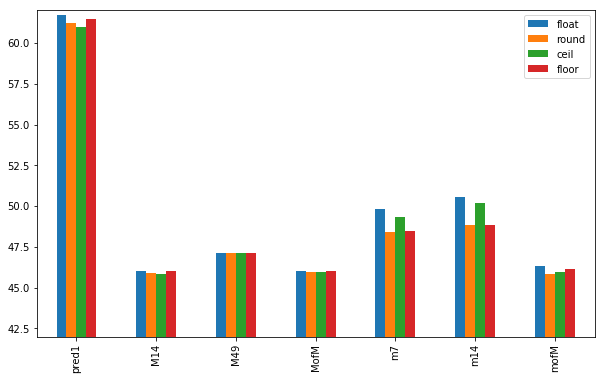

In [4]:
# Create sample predictions first as floating mumbers and again 
# as rounded to integers and then with ceiling  and floor
# to be compared with the "true" set of the last 60 days

predictions=['pred1','M14', 'M49', 'MofM',  'm7','m14','mofM']         # float
true=test['V60'].astype(int)
test['weight']=np.random.uniform(0,1,len(test))
test['pred1']=test['V120']*test['weight']+test['V180']*(1-test['weight'])

plt.clf()
s=pd.DataFrame(0,index=predictions,columns=['float','round','ceil','floor'])
for j in predictions:
    Float = smape(true,test[j])
    Round = smape(true,test[j].round().astype(int))
    Ceil = smape(true,np.ceil(test[j]))
    Floor = smape(true,np.floor(test[j]))
    s.loc[j,['float','round', 'ceil', 'floor']] = (Float,Round,Ceil,Floor)
    print('{:>7} is {:.2f} round {:.2f} ceil {:.2f} floor {:.2f} '.
          format(str(j),Float,Round,Ceil,Floor))

s.plot(kind='bar',ylim=(42,62), figsize=(10,6))
plt.show()


In [5]:
Float = smape(true,test['mofM'])
Round1 = smape(true,test['mofM'].round())
Round2 = smape(true,test['mofM'].where(test['mofM']>=0.5,0))
Round3 = smape(true,test['mofM'].where(test['mofM']>1,0))
print(' float {:.2f} round {:.2f}  1/2: {:.2f}  1: {:.2f}'.format(Float, Round1,Round2,Round3))

 float 46.34 round 45.86  1/2: 45.99  1: 46.10


We see that rounding is usually better than taking the ceiling or floor and also that most of the gain is from replacing values between 0 and 1/2 by 0 since by definition smape is 0 for 0/0 (even though rounding still matters for numbers greater than 1 as well).

Next we look at the weekly seasonality:

In [6]:
for i in ['D60','D120','D180']: test[i] = test[i].astype('datetime64[ns]')
test['wk_60']= test.D60.dt.dayofweek >=5  
test['wk_120']= test.D120.dt.dayofweek >=5  
test['wk_180']= test.D180.dt.dayofweek >=5  

In [7]:
colm=test.columns[7:7+len(Windows)]    # save the names of the median columns

cv=60    # chose 60 or 120 or 180 
if cv !=60:   
    tmp=train['Page'].to_frame()
    test1=test['Page'].to_frame()
    for i in Windows: tmp['M'+str(i)]=train.iloc[:,-i-cv:-cv].median(axis=1)
    test1=test1.merge(tmp, on = 'Page')
    for i in Windows: test['M'+str(i)]=test1['M'+str(i)]
    del tmp, test1

colmw=[]
for i in Windows:
    print(cv,i, end=' ')
    val='MW'+str(i)
    colmw=colmw+[val]
    tmp = pd.melt(train[list(train.columns[-i-cv:-cv])+['Page']], 
                  id_vars='Page', var_name='D', value_name=val)
    tmp['D'] = tmp['D'].astype('datetime64[ns]')
    tmp['wk_'+str(cv)]= tmp.D.dt.dayofweek  >= 5
    tmp1 = tmp.groupby(['Page','wk_'+str(cv)]).median().reset_index()
    test = test.merge(tmp1, how='left')

print(test.shape)
del tmp,tmp1
gc.collect()

60 7 60 14 60 28 60 35 60 42 60 49 60 56 (8703780, 30)


11073

Let us plot the score for the median prediction with (MW) and without (M) grouping by weekends as well as the median of medians of the medians (MMW) that take into account the seasonality. The last one starts with taking just two medians and ends with taking all. The conclusion is that taking the median of the full set of medians with weekly seasonality is better. 


 M smape from      M7 is 46.69 with wk 47.27 and MM nan
 M smape from     M14 is 46.04 with wk 46.08 and MM 47.11
 M smape from     M28 is 46.15 with wk 45.72 and MM 46.11
 M smape from     M35 is 46.36 with wk 45.84 and MM 45.30
 M smape from     M42 is 46.72 with wk 46.13 and MM 45.03
 M smape from     M49 is 47.12 with wk 46.53 and MM 45.13
 M smape from     M56 is 47.69 with wk 47.07 and MM 45.18


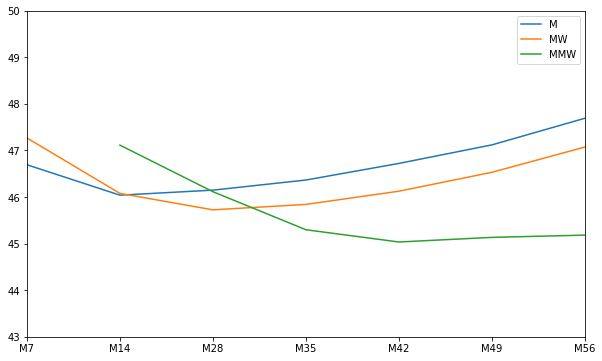

6208

In [8]:
plt.clf()
true=test['V'+str(cv)]
smape_all=pd.DataFrame(0,index=colm,columns=[ 'M','MW','MMW'])
for i in range(0,len(colm)) :   
    smape_all.loc[colm[i],'M'] = smape(true,test[colm[i]])
    smape_all.loc[colm[i],'MW'] = smape(true,test[colmw[i]])
    smape_all.loc[colm[i],'MMW'] = smape(true,test.loc[:,colmw[0:i]].median(axis=1).round())        
    print(' M smape from {:>7} is {:.2f} with wk {:.2f} and MM {:.2f}'.format(
        colm[i], smape_all.loc[colm[i],'M'],smape_all.loc[colm[i],'MW']
         ,smape_all.loc[colm[i],'MMW']))

test['MMW']=test.loc[:,colmw].median(axis=1).round()
smape_all.plot(ylim=(43,50), figsize=(10,6))
plt.show()    
gc.collect()

And finally:

In [9]:
#this scores 44.5 on LB  (and with one small modification 44.0, ie top 3% as of yesterday)

# define the Windows according to Ehsan's kernel
r = 1.61803398875  
Windows = np.round(r**np.arange(0,9) * 7).astype(int)

test = pd.read_csv('../input/key_1.csv')
test['Date'] = test.Page.apply(lambda x: x[-10:])
test['Page'] = test.Page.apply(lambda x: x[:-11])
test['Date'] = test['Date'].astype('datetime64[ns]')
test['wk']= test.Date.dt.dayofweek >=5

for i in Windows:
    print(i,end= ' ')
    val='MW'+str(i)
    tmp = pd.melt(train[list(train.columns[-i:])+['Page']], 
                  id_vars='Page', var_name='D', value_name=val)
    tmp['D'] = tmp['D'].astype('datetime64[ns]')
    tmp['wk']= tmp.D.dt.dayofweek  >=5           
    tmp1 = tmp.groupby(['Page','wk']).median().reset_index()
    test = test.merge(tmp1, how='left')
    
test['Visits']=test.iloc[:,4:].median(axis=1).round().astype(int)
test[['Id','Visits']].to_csv('sub.csv', index=False)
gc.collect()

7 11 18 30 48 78 126 203 329 

400